## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import moment

# Statsmodels
import statsmodels

from sklearn.metrics import mean_squared_error
import plotly.express as px

import time
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

import os
import random

import pmdarima as pm
import plotly.graph_objects as go

import pycountry_convert as pc
from scipy.signal import find_peaks


# Introdução
Nesse case será analisado os dados 

Dados
Os dados estão disponíveis em
https://www.bitre.gov.au/publications/ongoing/international_airline_activity-time_series , no arquivo ‘Airline by
country of port data–passengers, freight and mail–2009 to current International Airline Activity Table1 2009 to
current ́ no formato .xlsx

Os dados estão disponíveis na aba `Data`.
Nome Descrição
Month Mês da observação
Scheduled Operator Linha aérea
Country to/from País de Origem/Destino
Passengers In Quantidade de passageiros entrantes na Australia
Freight In Fretes entrantes na Australia, em toneladas
Mail In Correio entrante na Australia, em toneladas
Passengers Out Quantidade de passageiros saindo da Australia
Freight Out Fretes saindo da Australia, em toneladas
Mail Out Correio saindo da Australia, em toneladas

## Pre-processamento do dataset

### Importando dataset
Vamos importar o dataset e realizar o pre processamento de dados numéricos e dados faltantes

In [2]:
dataset_path = 'dataset.xlsx'
xl_file = pd.ExcelFile(dataset_path)
xl_file.sheet_names

['ReadMe', 'ExpNotes', 'Data Issues', 'Data', 'Totals']

In [3]:
sheet_name = 'Data'
dataset = pd.read_excel(dataset_path, sheet_name=sheet_name)

In [4]:
# Pegando a lista de colunas com valores numericos a serem tratadas
numeric_cols = list(dataset.columns[3:-1])

# Formatando valores numericos
dataset[numeric_cols] = dataset[numeric_cols].apply(lambda x:  pd.to_numeric(x, errors='coerce'))

In [5]:
numeric_cols

['Passengers In',
 'Freight In',
 'Mail In',
 'Passengers Out',
 'Freight Out',
 'Mail Out']

## Tratamento de valores faltantes em séries temporais
Existem várias formas de tratar de valores faltantes, desde descartar as linhas com valores faltantes, substituir pela média, mediana e até utilizar de interpolação para tratar esses valores. Em séries temporais somente o ultimo seria de alguma valia para manter o comportamento da série temporal e sua distribuição. Outra forma para tratar valores faltantes, especificamente para séries temporais, seria substituir pelo ultimo ou pelo proximo valor. Nesse case foi escolido a substituição pelo ultimo valor como forma de tratar outlier.

Dessa forma, Para tratar os valores faltantes vamos utilizar o `bfill` do pandas para utilizar o ultimo valor conhecido para substituir os valores `NaN`.

Como cada país tem um comportamento de série temporal diferente é necessário tratar os valores faltantes por país, para não acabar inserindo dados relativos de uma distribuição diferente no valor faltante.

In [6]:
unique_countries = list(dataset['Country to/from'].unique())

for country in unique_countries:
   dataset.loc[dataset['Country to/from'] == country] =  dataset.loc[dataset['Country to/from'] == country].bfill()
   dataset.loc[dataset['Country to/from'] == country] =  dataset.loc[dataset['Country to/from'] == country].ffill()

Agora vamos checar se ainda há valores faltantes

In [7]:
for col in list(dataset.columns):
    print(f'Coluna {col} | Quantidade de NaN {dataset[col].isnull().sum()} ')

Coluna Month | Quantidade de NaN 0 
Coluna Scheduled Operator | Quantidade de NaN 0 
Coluna Country to/from | Quantidade de NaN 0 
Coluna Passengers In | Quantidade de NaN 108 
Coluna Freight In | Quantidade de NaN 21 
Coluna Mail In | Quantidade de NaN 21 
Coluna Passengers Out | Quantidade de NaN 56 
Coluna Freight Out | Quantidade de NaN 0 
Coluna Mail Out | Quantidade de NaN 0 
Coluna Year | Quantidade de NaN 0 


Como ainda há a existencia de valores faltantes vamos tentar visualizá-los para entender a natureza desses dados.

In [8]:
dataset.loc[dataset['Passengers In'].isnull() == True].loc[dataset['Passengers Out'].isnull() == True]

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year
21,2009-01-01,Cargolux Airlines Intl,Luxembourg,NaN,65.050,0.0,NaN,0.000,0.000,2009
119,2009-02-01,Cargolux Airlines Intl,Luxembourg,NaN,95.452,0.0,NaN,0.000,0.000,2010
218,2009-03-01,Cargolux Airlines Intl,Luxembourg,NaN,102.769,0.0,NaN,0.000,0.000,2010
318,2009-04-01,Cargolux Airlines Intl,Luxembourg,NaN,100.283,0.0,NaN,0.000,0.000,2010
413,2009-05-01,Cargolux Airlines Intl,Luxembourg,NaN,153.084,0.0,NaN,0.000,0.000,2010
511,2009-06-01,Cargolux Airlines Intl,Luxembourg,NaN,98.543,0.0,NaN,0.000,0.000,2010
607,2009-07-01,Cargolux Airlines Intl,Luxembourg,NaN,77.821,0.0,NaN,0.000,0.000,2010
707,2009-08-01,Cargolux Airlines Intl,Luxembourg,NaN,131.779,0.0,NaN,0.000,0.000,2010
808,2009-09-01,Cargolux Airlines Intl,Luxembourg,NaN,108.767,0.0,NaN,0.000,0.000,2010
907,2009-10-01,Cargolux Airlines Intl,Luxembourg,NaN,172.680,0.0,NaN,0.000,0.000,2010


Podemos ver que além de poucas ocorrências os valores nulos acontecem majoritariamente acompanhados do mesmo país e mesma companhia aérea. Dessa forma, a natureza desses dados possivelmente deve estar relacionada com imputação errónea da parte da companhia aérea. Dessa forma esses valores serão removidos do dataset.

In [9]:
dataset = dataset.dropna()
for col in list(dataset.columns):
    print(f'Coluna {col} | Quantidade de NaN {dataset[col].isnull().sum()} ')

Coluna Month | Quantidade de NaN 0 
Coluna Scheduled Operator | Quantidade de NaN 0 
Coluna Country to/from | Quantidade de NaN 0 
Coluna Passengers In | Quantidade de NaN 0 
Coluna Freight In | Quantidade de NaN 0 
Coluna Mail In | Quantidade de NaN 0 
Coluna Passengers Out | Quantidade de NaN 0 
Coluna Freight Out | Quantidade de NaN 0 
Coluna Mail Out | Quantidade de NaN 0 
Coluna Year | Quantidade de NaN 0 


In [10]:
# Formatando o campo de data
dataset['date'] = pd.to_datetime(dataset['Month'], format="%Y-%m-%d")
dataset.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,date
0,2009-01-01,Aerolineas Argentinas,Argentina,3021.0,4.313,0.600,1959.0,8.311,0.000,2009,2009-01-01
1,2009-01-01,Aerolineas Argentinas,New Zealand,627.0,76.260,0.000,1821.0,68.539,0.000,2009,2009-01-01
2,2009-01-01,Air Caledonie,New Caledonia,6658.0,4.918,0.645,5365.0,68.621,1.291,2009,2009-01-01
3,2009-01-01,Air Canada,Canada,7489.0,174.828,0.004,6424.0,105.191,0.016,2009,2009-01-01
4,2009-01-01,Air China,China,12458.0,201.314,18.569,11163.0,142.408,2.930,2009,2009-01-01


## Inserindo a noção de continente de partida no dataset
Para isso será utilizado pycountry_convert, porém como vamos ver mais adiante isso pode nos causar alguns erros, como países os quais não conseguem ser identificados pelo módulo. Assim foi necessário o mapeamento manual dos países os quais não tiveram continentes correspondentes.

In [11]:
# inserindo coluna de continente de partida
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    except (KeyError, TypeError):
        return 'error'
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [12]:
dataset['Continent'] = dataset['Country to/from'].apply(lambda x: country_to_continent(x))

In [13]:
# Avaliando causas de erro na transformação de país de origem para continente de origem
country_error_samples = list(dataset.loc[dataset['Continent'] == 'error']['Country to/from'].unique())
country_error_samples

['Tahiti', 'Korea', 'UK', 'Hong Kong (SAR)', 'Western Samoa', 'Reunion']

In [14]:
# Criando mapa manual das causas de erro
country_error_map = {'Tahiti'         : 'Oceania',
                     'Korea'          : 'Asia',
                     'UK'             : 'Europe',
                     'Hong Kong (SAR)': 'Asia',
                     'Western Samoa'  : 'Oceania',
                     'Reunion'        : 'Africa'
}

# Aplicando o mapa no dataset
for country in list(country_error_map.keys()):
    dataset.loc[dataset['Country to/from'] == country, 'Continent'] = country_error_map[country]

# Análise exploratória

## Inserindo a noção de semestre no dataframe
Vamos agora inserir a noção de semestre no dataframe e verificar a média para cada semestre, para verificar se existe uma diferença na média do número de passageiros de acordo com o semestre

In [15]:
dataset['year']    = dataset['date'].dt.year
dataset['Month']   = dataset['date'].dt.month
dataset['day']     = dataset['date'].dt.dayofyear
dataset['quarter'] = dataset['date'].dt.quarter

## Verificando a relação de semestre e número de passageiros

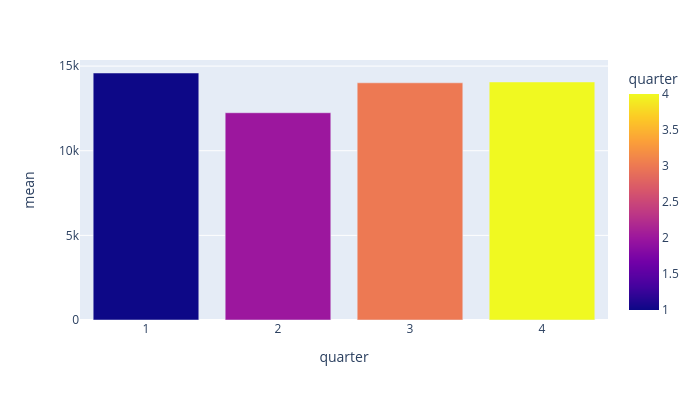

In [16]:
def plot_mean_by_col(col):
    bar_df = {"mean": []}
    bar_df[col] = []

    for value in range(dataset[col].min(),dataset[col].max() + 1):
        bar_df[col].append(value)
        bar_df["mean"].append(dataset[(dataset[col] == value)]['Passengers In'].mean())

    fig = px.bar(bar_df, x=col, y='mean', color=col,
                labels={'Mean value per quarter'}, height=400)
    fig.show('png')

plot_mean_by_col('quarter')

## Correlação de ano em relação ao número de passageiros

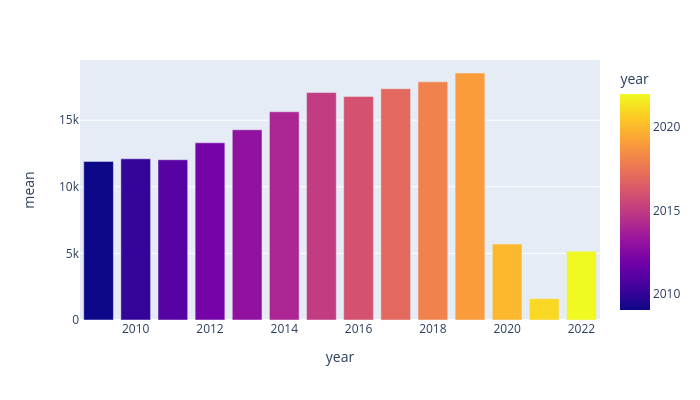

In [17]:
plot_mean_by_col('year')

Analisando-se o gráfico acima é possível notar a influencia clara da pandemia do `covid-19` em relação ao número de passageiros. Até o ano de 2019 era possível notar uma tendência de subida na média de passageiros, porém em 2020 ja foi possível notar a queda considerável do número de passageiros.

## Analisando a série temporal de um dos continentes
Vamos agora selecionar uma série temporal e realizar a inspeção visual.

In [18]:
item_train_set = dataset[(dataset['Continent'] == 'Asia')]

In [19]:
item_train_set.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,date,Continent,year,day,quarter
4,1,Air China,China,12458.0,201.314,18.569,11163.0,142.408,2.93,2009,2009-01-01,Asia,2009,1,1
14,1,AirAsia X,Malaysia,21143.0,106.524,0.000,17676.0,57.274,0.00,2009,2009-01-01,Asia,2009,1,1
16,1,Airnorth,Indonesia,397.0,0.000,0.000,325.0,0.000,0.00,2009,2009-01-01,Asia,2009,1,1
17,1,Asiana Airlines,Korea,8996.0,164.319,7.170,7684.0,74.990,0.00,2009,2009-01-01,Asia,2009,1,1
18,1,British Airways,Singapore,2602.0,114.784,0.000,2064.0,156.193,0.00,2009,2009-01-01,Asia,2009,1,1


Ao olhar a tabela gerada selecionando a Asia como continente, é possível notar um problema, a cada passo de tempo temos multiplos valores de número de passageiros, os quais são fornecidos por cada agencia de vôo. Assim é necessário primeiramente agrupar os valores numéricos da tabela por data.

In [20]:
numeric_cols = ['Passengers In','Freight In','Mail In','Passengers Out','Freight Out','Mail Out']
item_train_set = item_train_set.groupby(item_train_set.date.dt.date)[numeric_cols].sum()
item_train_set = item_train_set.reset_index()
item_train_set['date'] = pd.to_datetime(item_train_set['date'], format="%Y-%m-%d")
item_train_set['quarter'] = item_train_set['date'].dt.quarter
item_train_set.head()

,date,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,quarter
0,2009-01-01,811923.0,17704.257,1290.664,648098.0,21150.281,443.440,1
1,2009-02-01,639633.0,18032.926,998.258,492025.0,20802.984,354.804,1
2,2009-03-01,580486.0,22832.144,1083.058,576671.0,22594.186,416.246,1
3,2009-04-01,577752.0,20397.789,1110.408,599690.0,19859.029,369.837,2
4,2009-05-01,505056.0,21683.527,1237.992,573690.0,17563.889,387.354,2


Agora a cada dia temos valores numéricos para a nossa tabela.

Agora vamos realizar a visualização e análise da série temporal principal, a de passageiros.

## Comportamento da série de passageiros

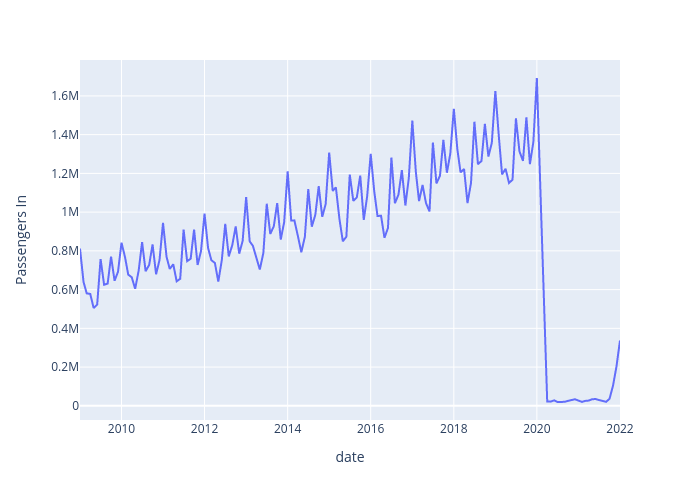

In [21]:

fig = px.line(item_train_set, x='date', y='Passengers In')
fig.show('png')

Olhando o gráfico acima é possível notar a presença de picos anuais e dois pequenos picos que antecedem o anual. Agora vamos visualizar o dado novamente com visualizando o numero do semestre a cada pico, para entender se os picos estão relacionados com o semestre.

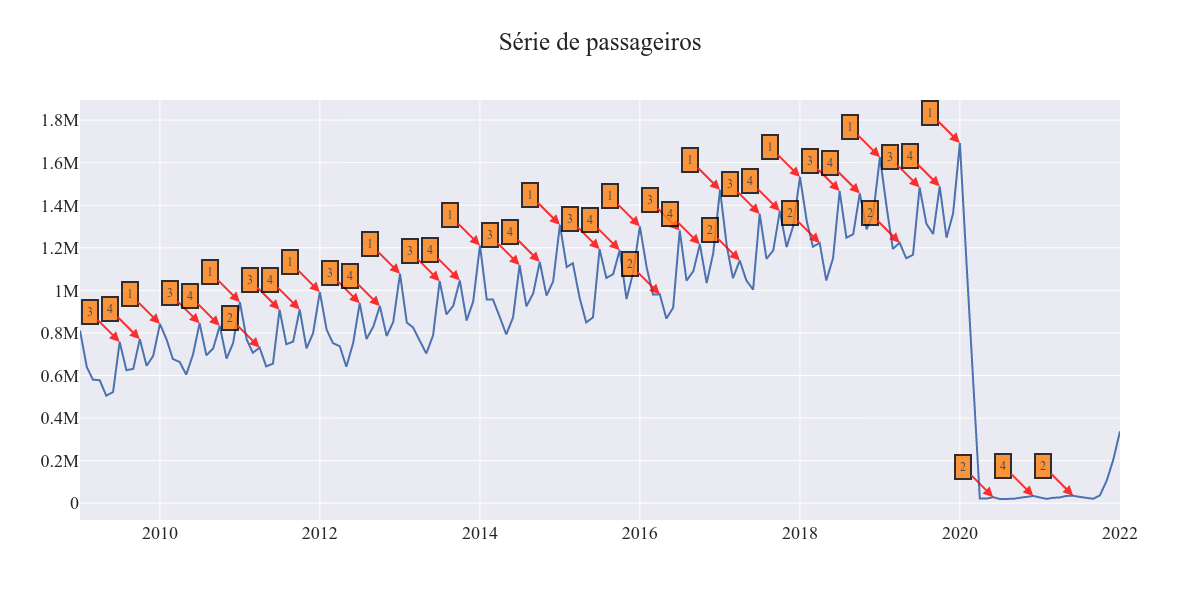

In [22]:
fig = go.Figure(data=go.Scatter(y=item_train_set['Passengers In'], x=item_train_set['date']))

all_peaks_indices = np.array([])
indices = find_peaks(item_train_set['Passengers In'], distance = 3,)[0]

for idx in indices:
    xref = 'x'
    yref = 'y'
    fig.add_annotation(
            x=item_train_set['date'][idx],
            y=item_train_set['Passengers In'][idx],
            xref=xref,
            yref=yref,
            text=f"{item_train_set['quarter'][idx]}",
            showarrow=True,
            font=dict(
                size=12,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=-30,
            ay=-30,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Série de passageiros',

)
fig.show('png')

Assim é possível notar que o pico anual sempre acontece no primeiro trimestre, seguindo desse pico acontece os picos dos trimestres 3 e 4, e por ultimo o menor pico anual é sempre no segundo trimestre.

## Autocorrelação da série temporal e análise
Agora vamos visualizar a autocorrelação da série temporal e tentar identificar padrões sazonais.

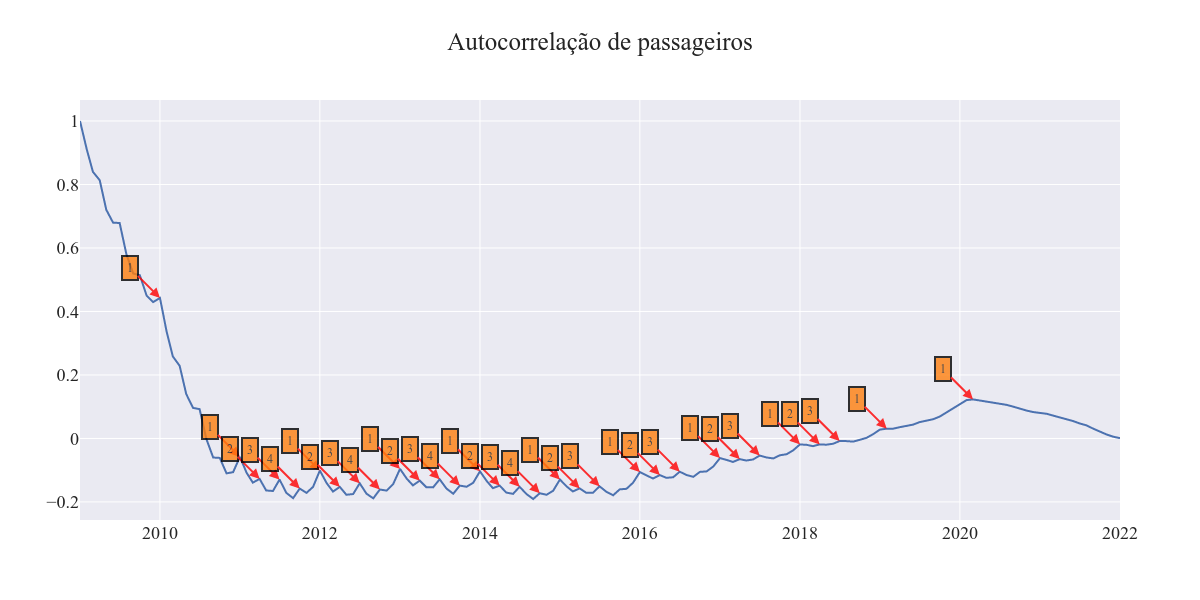

In [23]:
item_train_set['auto_corr'] = statsmodels.tsa.stattools.acf(item_train_set['Passengers In'].values, nlags = len(item_train_set), fft=False)

fig = go.Figure(data=go.Scatter( x=item_train_set['date'], y=item_train_set['auto_corr']))
all_peaks_indices = np.array([])
indices = find_peaks(item_train_set['auto_corr'], distance = 3,)[0]

for idx in indices:
    xref = 'x'
    yref = 'y'
    fig.add_annotation(
            x=item_train_set['date'][idx],
            y=item_train_set['auto_corr'][idx],
            xref=xref,
            yref=yref,
            text=f"{item_train_set['quarter'][idx]}",
            showarrow=True,
            font=dict(
                size=12,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=-30,
            ay=-30,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Autocorrelação de passageiros',

)
fig.show('png')

A partir do gráfico de autocorrelação e da inspeção visual da série é possível afirmar que a série temporal de passageiros possui um padrão que se repete anualmente. Isso é possível de se afirmar ao observar que os picos de autocorrelação se repetem a cada ano, dessa forma a série temporal de passageiros possui um padrão anual.

De forma semelhante é possível identificar padrões sazonais a cada semestre, visualizando os pequenos picos que antecedem os picos anuais de autocorrelação.

## Teste de estacionaridade no sentido amplo
Uma das análises mais importantes de dados de séries temporais é detectar se a série em questão é estacionária em sentido amplo ou não estacionária. Estacionaridade em sentido amplo de uma série temporal é uma característica que assegura que a série temporal não apresenta uma tendencia forte de descida ou subida e que esta série não apresenta sazonalidade. Utilizando-se dos dados de autocorrelação ja é um forte indicativo que a série temporal apresenta sazonalidade anual e somente utilizando essa informação é possível afirmar que a nossa série é não estacionária no sentido amplo. Porém podemos confirmar essa hipótese utilizando o teste de estacionaridade.

Muitos autores de artigos que utilizam machine learning para séries temporais defendem que usar esse tipo de modelo de aprendizado de máquina não exige necessariamente que os dados já estejam estacionários. No entanto, é importante saber se os dados são estacionários mesmo que o modelo selecionado seja baseado em ML, pois se o modelo não convergir bem isso pode ser uma causa e conhecer as propriedades da série também é muito valioso.

[1] Defina uma série temporal estacionária fraca se a função média $ E[x(t)] $ for independente de $ t $, se a função de autocoraviação $Cov (x(t+h), x(t))$ for independente de $ t $ para cada $h$ e se $E[x^2[n]]$ for finito para cada $n$.

Para realizar o teste de estacionaridade, a função média e a função de autocovariação foram aplicadas sobre janelas rolantes, desde seus dados amostrados. Assim, o tamanho da janela tem impacto sobre as interpretações das funções, a janela representa o intervalo em que a hipótese estacionária é testada.

Além desta definição, a biblioteca $ statsmodels $ possui o teste de raiz unitária Augmented Dickey-Fuller. O teste Augmented Dickey-Fuller pode ser usado para testar uma raiz unitária em um processo univariado na presença de correlação sazonal.

Referências
[1] Brockwell, Peter J. e Richard A. Davis. Introdução às séries temporais e previsão. Springer, 2016.

In [24]:
def stationary_test(entry,delta=200,ad=False,std=False):
    window_size=int(len(entry)/15)
    # Weak stationary test
    # Mean function
    mean_y = []
    mean_x = []

    s_moment_y = []
    std_y = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size)):
        # Roling window start and end
        n_start = i
        n_end = n_start + window_size
        # Mean, standard deviation and second moment calculation
        mean_y_i = np.mean(entry[n_start:n_end])
        s_moment_y_i = moment(entry[n_start:n_end],moment=2)
        std_y_i = np.std(entry[n_start:n_end])
        # Saving the results 
        mean_y.append(mean_y_i)
        mean_x.append(n_end)
        s_moment_y.append(s_moment_y_i)
        std_y.append(std_y_i)

    # Autocovariance function
    acov_y = []
    acov_x = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size - delta)):
        n_start = i
        n_end = n_start + window_size
        acov_y_i = np.cov(
            entry[n_start:n_end], entry[n_start+delta:n_end+delta]
        )[0][0]
        acov_y.append(acov_y_i)
        acov_x.append(n_end)
    if(ad):
        result = adfuller(entry)
        print("ADF Statistic: %f" % result[0])
        print("p-value: {0}".format(result[1]))
        print("Critical Values:")
        for key, value in result[4].items():
            print("\t%s: %.3f" % (key, value))
        # if the p-value < 0.05  and the adf statistic is less than
        # critical values the series is stationary or is time independent
    return [mean_x,mean_y],[acov_x,acov_y], s_moment_y, std_y

ADF Statistic: -2.803527
p-value: 0.057771761696075286
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


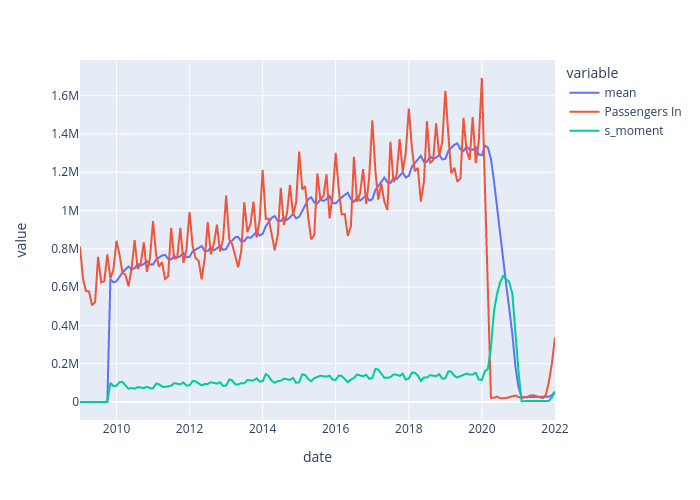

In [25]:
# Weak stationary test
sales_train = item_train_set['Passengers In'].to_numpy()

mean, cov, s_moment, std = stationary_test(sales_train, delta=20,ad=True)
mean_value = np.zeros(len(sales_train))
mean_value[mean[0][0]:] = mean[1]

cov_value = np.zeros(len(sales_train))
cov_value[cov[0][0]:len(cov[1])+cov[0][0]] = cov[1]

std_value = np.zeros(len(sales_train))
std_value[mean[0][0]:] = std

s_moment_value = np.zeros(len(sales_train))
s_moment_value[mean[0][0]:] = s_moment

item_train_set['mean'] = mean_value
item_train_set['cov'] = cov_value
item_train_set['s_moment'] = std_value

fig = px.line(item_train_set, x='date', y=['mean', 'Passengers In', 's_moment'])
fig.show('png')

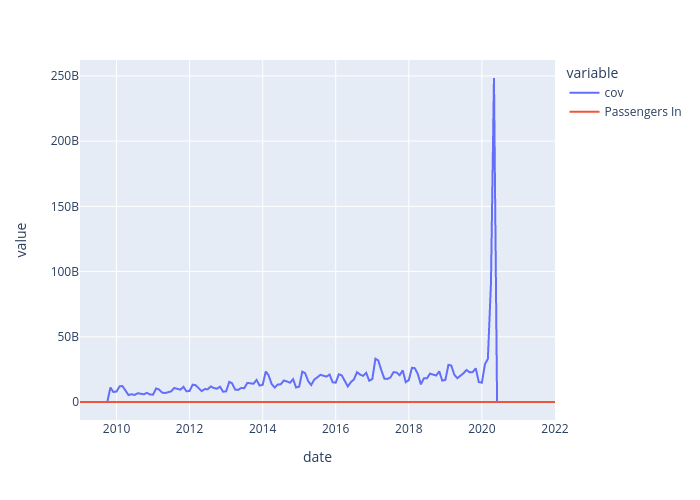

In [26]:

fig = px.line(item_train_set, x='date', y=['cov', 'Passengers In'])
fig.show('png')

## Analisando os resultados do teste
A hipótese de teste da função média falhou, isto pode ser observado verificando a função seguindo a tendência e a sazonalidade das séries de vendas, a função de covariação apresenta um comportamento de crescimento explosivo. A função de segundo momento não mostra uma tendência para o infinito com qualquer $n$, passando dessa forma esta condição.

Analisando os gráficos de funções é correto inferir que esta série de vendas não é estacionária, isto também pode ser observado no gráfico de autocorrelação, que mostra um comportamento de decadência lenta.o gráfico de autocorrelação mostra também um comportamento periódico, que representa um comportamento periódico na série temporal.

Além dos testes de estatística em janela, o teste de Dickey-Fuller implementado pode ser feito para verificar se a série de vendas é estacionária ou não. Este teste verifica se a série tem uma raiz unitária e, ao fazê-lo, pode fazer a suposição de quanto a série é definida pela sua tendência.

Existem 2 Hipóteses:

Hipótese Nula (H0): Se não for rejeitada, sugere que a série tem uma raiz unitária, o que significa que é não-estacionária. Tem alguma estrutura dependente do tempo.

Hipótese alternativa (H1): A hipótese nula é rejeitada; sugere que a série não tem uma raiz unitária, o que significa que é estacionária. Não tem uma estrutura dependente do tempo.

Interpretamos este resultado utilizando o valor p do teste. Um valor p abaixo de um limiar (como 5% ou 1%) sugere que rejeitamos a hipótese nula (estacionária), caso contrário, um valor p acima do limiar sugere que não rejeitamos a hipótese nula (não estacionária).

p-valor > 0,05: Não rejeitar a hipótese nula (H0), os dados têm uma raiz unitária e são não-estacionários.
p-valor <= 0,05: Rejeitar a hipótese nula (H0), os dados não têm uma raiz unitária e são estacionários.

Uma vez que o valor p do valor do teste aplicado à série é superior a 0,05, a hipótese nula é rejeitada, assim a série é não estacionária

## Correlação de número de passageiros com as outras variáveis
Agora vamos analisar a correlação de número de passageiros com as outras variáveis para verificar se estas serão boas features para os nossos modelos

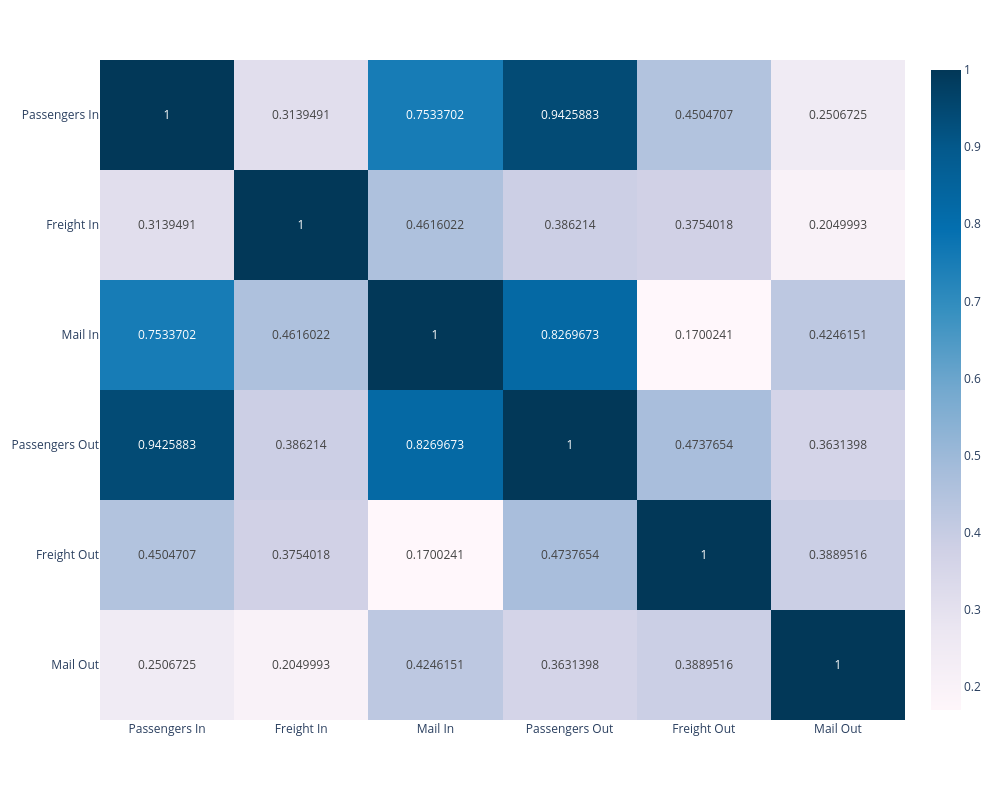

In [27]:
fig = px.imshow(item_train_set[numeric_cols].corr(), text_auto=True ,color_continuous_scale='PuBu', width=1000, height=800, aspect="auto")
fig.show('png')

 A partir do gráfico correlação cruzada é possível concluir que as variáveis de 'Pasengers Out' e 'Mail in' tem uma correlação boa em relação ao numero de passageiros 'Passengers in', porém também é possível observar que 'Pasengers Out' e 'Mail in' tem uma correlação grande entre si, o que pode significar colinearidade.